# Построение рекомендательной системы с помощью Surprise

In [68]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import gzip
import json

from surprise import Dataset, Reader
from surprise import KNNBasic, SVD, AlgoBase, accuracy

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 1. EDA

Датасет с отзывами о музыкальных релизах (Digital Music).

Интересующие нас колонки:
* reviewerID
* asin - id релиза
* overall - оценка релиза

Решаем классическую задачу предсказания рейтинга релиза

In [3]:
df = getDF('Digital_Music_5.json.gz')
df

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
169776,5.0,NaN,True,"08 19, 2018",A1SR2T84IXOMAQ,B01HJ91MTW,{'Format:': ' MP3 Music'},Diane B.,Casting Crowns songs are all wonderful!!,Great song!!,1534636800,NaN
169777,5.0,NaN,True,"03 18, 2018",A2SR3DWJR1PYR6,B01HJ91MTW,{'Format:': ' MP3 Music'},jan c.,Just reminds you that you are never alone.,Five Stars,1521331200,NaN
169778,5.0,NaN,True,"03 7, 2018",A24V7X30NIMOIY,B01HJ91MTW,{'Format:': ' MP3 Music'},Lori Y,"Good product, good service.",Five Stars,1520380800,NaN
169779,5.0,NaN,True,"02 12, 2018",A1LW10GYP2EYM1,B01HJ91MTW,{'Format:': ' MP3 Music'},N F,I love every single song this group sings. The...,Absolutely beautiful...,1518393600,NaN


In [4]:
df.isna().sum()

overall                0
vote              162170
verified               0
reviewTime             0
reviewerID             0
asin                   0
style              11792
reviewerName           5
reviewText           158
summary               36
unixReviewTime         0
image             169599
dtype: int64

Как видно, в основном высокие оценки.

In [5]:
df.overall.value_counts()

5.0    135842
4.0     23143
3.0      6792
1.0      2192
2.0      1812
Name: overall, dtype: int64

Не похоже, что есть смысл разделять тип носителя релиза.

In [6]:
df['style'].value_counts()

{'Format:': ' MP3 Music'}         146766
{'Format:': ' Audio CD'}           10815
{'Format:': ' Vinyl'}                345
{'Format:': ' DVD'}                   26
{'Format:': ' Audio Cassette'}        14
{'Format:': ' Blu-ray Audio'}          8
{'Format:': ' Blu-ray'}                7
{'Format:': ' Vinyl Bound'}            4
{'Format:': ' Amazon Video'}           3
{'Format:': ' DVD Audio'}              1
Name: style, dtype: int64

Количество пользователей и отзывов.

In [7]:
df.reviewerID.nunique(), df.asin.nunique()

(16566, 11797)

В описании гарантировалось, что для каждого релиза/пользователя не менее 5 отзывов, но, как видно, это не так. Есть смысл отфильтровать такие отзывы, т.к. они не помогут в решении задачи.

In [8]:
df.asin.value_counts().min(), df.reviewerID.value_counts().min()

(1, 1)

Еще один момент, который нужно фильтровать - как видно, некоторые пользователи спамят отзывами на один и тот же релиз. Необходимо оставить только уникальные пары пользователь - релиз.

In [9]:
df[['reviewerID', 'asin']].value_counts()

reviewerID      asin      
A3DG93E8TXMKZF  B001KOWH0G    52
A23OB9FM3MUYXT  B00137ILRS    18
                B000VWMT7Y    12
AWG2O9C42XW5G   9434682614    10
A23OB9FM3MUYXT  B00137MMAU    10
                              ..
A2DY7N9SKROB5I  B00137OCY4     1
                B000VWGZ8S     1
                B000VH2YME     1
                B000V6PAHG     1
AZZHILYMITLGM   B00GLP4GC6     1
Length: 145292, dtype: int64

In [10]:
df[(df.reviewerID == 'A3DG93E8TXMKZF') & (df.asin == 'B001KOWH0G')].head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
56566,1.0,NaN,True,"04 15, 2014",A3DG93E8TXMKZF,B001KOWH0G,{'Format:': ' MP3 Music'},JohnAroundTheCornerReviews,This is NOT a piece of music.\n\nIt is only us...,"All this is is a single tone, DO NOT DOWNLOAD.",1397520000,NaN
56567,1.0,NaN,True,"04 15, 2014",A3DG93E8TXMKZF,B001KOWH0G,{'Format:': ' MP3 Music'},JohnAroundTheCornerReviews,This is NOT a piece of music.\n\nIt is only us...,"All this is is a single tone, DO NOT DOWNLOAD.",1397520000,NaN
56568,1.0,NaN,True,"04 15, 2014",A3DG93E8TXMKZF,B001KOWH0G,{'Format:': ' MP3 Music'},JohnAroundTheCornerReviews,This is NOT a piece of music.\n\nIt is only us...,"All this is is a single tone, DO NOT DOWNLOAD.",1397520000,NaN
56569,1.0,NaN,True,"04 15, 2014",A3DG93E8TXMKZF,B001KOWH0G,{'Format:': ' MP3 Music'},JohnAroundTheCornerReviews,This is NOT a piece of music.\n\nIt is only us...,"All this is is a single tone, DO NOT DOWNLOAD.",1397520000,NaN
56570,1.0,NaN,True,"04 15, 2014",A3DG93E8TXMKZF,B001KOWH0G,{'Format:': ' MP3 Music'},JohnAroundTheCornerReviews,This is NOT a piece of music.\n\nIt is only us...,"All this is is a single tone, DO NOT DOWNLOAD.",1397520000,NaN


Интересно взглянуть на завиимость рейтинга от времени в общем, если такая существует. Как видно, разброс по времени довольно большой - 20 лет.

In [17]:
pd.to_datetime(df.unixReviewTime.min(), unit='s').date(), pd.to_datetime(df.unixReviewTime.max(), unit='s').date()

(datetime.date(1998, 7, 9), datetime.date(2018, 9, 26))

In [18]:
df['reviewTime'] = df.unixReviewTime.apply(lambda x: pd.to_datetime(x, unit='s').date())
df['reviewMonth'] = df.reviewTime.apply(lambda x: (x.year, x.month))

Сожмем данные по месяцу, чтобы посмотреть зависимость. Очевидно, с течением ремени отзывов становится больше и связано это с развитием интернета. Хотя есть странный спад ближе к 2018 году.

<AxesSubplot:xlabel='reviewMonth'>

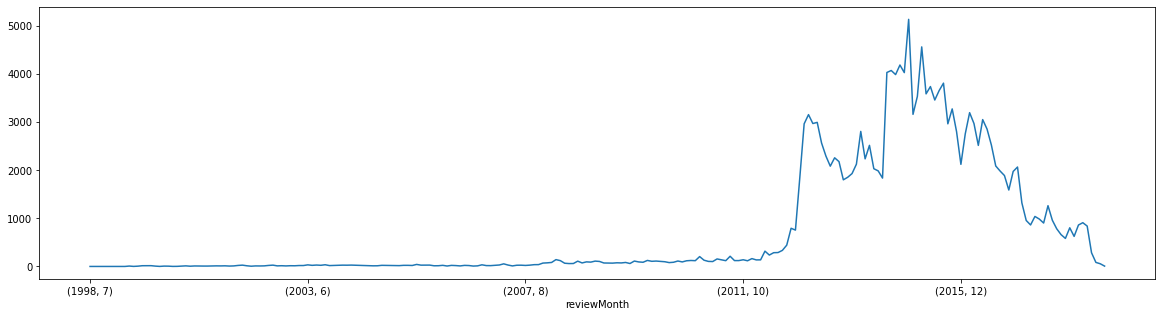

In [80]:
df.groupby('reviewMonth').overall.count().plot(figsize=(20, 5))

При этом с поправкой на количество отзывов нельзя сказать, что со временем рейтинги существенно меняются. Мы видим, что в среднем с 2011 года оценки поднялись, но при этом количество отзывов возросло многократно.

<AxesSubplot:xlabel='reviewMonth'>

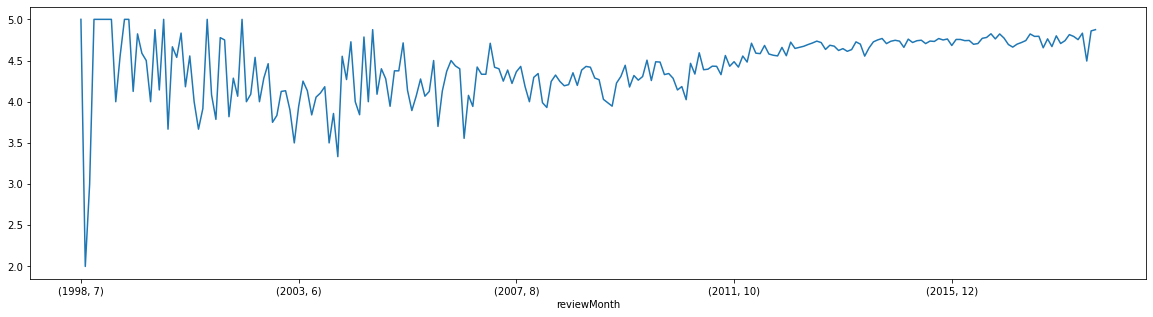

In [87]:
df.groupby('reviewMonth').overall.mean().plot(figsize=(20, 5))

## 2. Train test split

Сначала удалим дубликаты и редкие отзывы.

In [43]:
asin_counts = df.asin.value_counts()
reviewer_counts = df.reviewerID.value_counts()

In [47]:
data = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']].drop_duplicates(subset=['reviewerID', 'asin'])
data = data[
    (data.reviewerID.isin(reviewer_counts[reviewer_counts >= 5].index)) &
    (data.asin.isin(asin_counts[asin_counts >= 5].index))
]
data.shape

(143986, 4)

Для разделения датасета так же будем учитывать время, если вдруг вкусы пользователей менялись. Код взят из лекции.

In [65]:
def train_test_split(X, ratio=0.2, user_col='reviewerID', item_col='asin',
                     rating_col='overall', time_col='unixReviewTime'):
    X.sort_values(by=[time_col], inplace=True)
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    for userId in tqdm(userIds):
        curUser = X[X[user_col] == userId]
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col, rating_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col, rating_col]].iloc[idx:, :].values)
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col, rating_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col, rating_col])
    return X_train, X_test

In [66]:
train, test = train_test_split(data)

  0%|          | 0/16510 [00:00<?, ?it/s]

In [118]:
reader = Reader(rating_scale=(1, 5))
X_train = Dataset.load_from_df(train, reader)
X_train = X_train.build_full_trainset()

In [156]:
X_test = test.values.tolist()

## 3. Models training

Обучим несколько моделей и сравним их между собой

### 3.1. Custom model

Будет возвращать для пользователя среднюю оценку среди всех, которые он поставил

In [434]:
class CustomAlgo(AlgoBase):

    def __init__(self):

        AlgoBase.__init__(self)
    
    def fit(self, trainset):
        
        AlgoBase.fit(self, trainset)

    def estimate(self, u, i):

        # if self.trainset.knows_user(u):
        if u in self.trainset.ur:
            return np.mean([x[1] for x in self.trainset.ur[u]])
        
        return 4.5

In [435]:
custom = CustomAlgo()
custom.fit(X_train)

In [436]:
custom_preds = custom.test(X_test)
accuracy.rmse(custom_preds)

RMSE: 0.5935


0.5935484900533535

### 3.2. KNN model

Построим item-based модель

In [213]:
%%time
knn = KNNBasic(sim_options={"user_based": False})
knn.fit(X_train)

Computing the msd similarity matrix...
Done computing similarity matrix.
CPU times: user 1.44 s, sys: 879 ms, total: 2.32 s
Wall time: 2.31 s


In [214]:
knn_preds = knn.test(X_test)
accuracy.rmse(knn_preds)

RMSE: 0.6479


0.6478626785901986

Интересно, что user_based модель показывала результаты гораздо хуже. Скорее всего, это связано с низкой вариативностью оценок в общем.

### 3.3. SVD

In [393]:
%%time
svd = SVD(n_factors=50, n_epochs=50, reg_all=0.05)
svd.fit(X_train)

CPU times: user 1.77 s, sys: 5.97 ms, total: 1.77 s
Wall time: 1.77 s


In [394]:
svd_preds = svd.test(X_test)
accuracy.rmse(svd_preds)

RMSE: 0.5798


0.579831866285516

Лучшая модель из трех

## 4. RecSys

Домашнее задание - построить рекомендательную систему, а не просто научиться предсказывать оценки.
Для начала стоит проверить, насколько вообще модель выдет похожие айтемы. К сожалению, мне не удалось найти какие-либо метаданные по id айтемов, поэтому можно косвенно опираться только на текст отзыва.

Например, первый отзыв в данных был посвящен, очевидно, группе Slayer. Лего будет оценить ближайшие айтемы - они должны быть посвящены так же металлу, желательно треш-металлу.

In [254]:
df.loc[0, ['reviewerID', 'asin', 'summary']]

reviewerID    A2TYZ821XXK2YZ
asin              3426958910
summary        Slayer Rules!
Name: 0, dtype: object

In [243]:
X_train.to_inner_iid("3426958910")

2160

Для начала посмотрим, что выдает простой алгоритм knn

In [223]:
sims = [knn.trainset.to_raw_iid(x) for x in knn.get_neighbors(2160, 5)]

In [224]:
for asin in sims:
    print(df[df.asin == asin].summary.unique()[:5])

['Insane album. Possibly their heaviest and their best.'
 '"Kill The Flaw" is great!' 'First Review, And A Positive One At That'
 "It's better than pop music" 'Support 7D']
['The Hellion!' 'good album' 'Five Stars' 'great album cover'
 'Classic Vengence']
['top of the line JH'
 'Mining the depths of "experience Hendrix" with only a few nuggets to show...but good for a short live album.'
 'And here, after a mere 45 yearsan erstwhile neglected star performance'
 'BEST FOR YOUR DOLLAR!!' 'There was nothing like him before or since']
['Four-and-a-Half Stars' 'A virtual "best of Down" compilation' 'MUST OWN'
 "Great live album, until Phil's voice goes downhill" 'Five Stars']
['Megadeth, Rattling Heads Again' 'Four Stars' 'They still got it' '666'
 'Good return!']


Судя по всему близко, явно альбомы тяжелой музыки. Смущает только Джимми Хендрикс И некий Фил (Коллинз?).

Посмотрим, что выдаст SVD. Для этого нужно построить матрицу близости, и , очевидно, на больших данных поиск ближайших айтемов должен выглядеть иначе.

In [412]:
svd.sim_options = {"user_based": False}
svd_matrix = svd.compute_similarities()

In [413]:
svd_matrix.shape

(11341, 11341)

In [365]:
sims = [svd.trainset.to_raw_iid(x) for x in np.argsort(svd_matrix[2160])[::-1][:5]]

In [366]:
for asin in sims:
    print(df[df.asin == asin].summary.unique()[:5])

['The Hellion!' 'good album' 'Five Stars' 'great album cover'
 'Classic Vengence']
['Papa III' 'Nameless Ghoul' 'Five Stars'
 'Just the right amount of everything' 'Best one yet!']
['Perfextion' 'Fantstic as always' 'About Time!! :)' 'Five Stars'
 'Four Stars']
['Cool' 'Thrash Returns' 'Five Stars' 'Three Stars'
 'Favorite of the Three Released (thus far)']
['Five Stars' 'awesome album, the only track that is missing from ...'
 'Cool Collection of hits....' 'Fair to midding' 'Four Stars']


Треш и хэви-метал присутствует, значит модель работает.

Рексистема же будет работать следующим образом - для заданного пользователя предсказывать рейтинг для всех возможных айтемов, фильтровать те, что он уже оценил, и выдавать айтемы с самой высокой оценкой.

In [439]:
def get_items(user, top_n=5):
    
    candidates = []
    
    uid = svd.trainset.to_inner_uid(user)
    reviewed = [x[0] for x in svd.trainset.ur[uid]]
    for iid in svd.trainset.all_items():
        if iid in reviewed:
            continue
        item = svd.trainset.to_raw_iid(iid)
        # pred = svd.predict(user, item).est
        pred = svd.estimate(uid, iid)
        candidates.append([pred, item])
        
    return sorted(candidates, reverse=True)[:top_n]

Рекомендуем айтемы для любителя Slayer

In [440]:
preds = get_items("A2TYZ821XXK2YZ")
preds

[[5.3673169481087735, 'B00EWS7JW8'],
 [5.3571868355611105, 'B00LY5GOZU'],
 [5.3405839889802476, 'B001BZF788'],
 [5.317536046136974, 'B000S55TTY'],
 [5.310077718913262, 'B00K9A8UQW']]

In [441]:
for _, asin in preds:
    # print(df[df.asin == asin].reviewText.unique()[:3])
    print(df[df.asin == asin].summary.unique()[:5])

['Ocean' 'Excellent'
 'Exactly what I wanted to add to my inspirational music playlist'
 'great lyrics.' 'Five Stars']
["the bus came by and i got on that's when it all begain"
 'Fine Wine In Wichita' 'already diggin it...'
 'Beat It On Down The Line To Wichita'
 '"Another Excellent DEAD Show From \'72 Already SOLD OUT......!"']
['Five Stars' 'AMAZING GRACE IT IS!!!'
 'Truly, Truly Amazing Sweet Heaven Above' 'The Essence Of Gospel Music'
 'The Gospel According to Aretha']
['Awesome !!!!' "Come on it's Joe Cocker......" 'Good price!' 'Five Stars'
 'Up Where He Belonged']
['Five Stars' 'this is a very nice piece by Mali'
 'The Gospel Free And True...' 'God is in control, listen up.'
 'Awesome lyrics the author spends time in the present of ...']


Не похоже на хорошие рекомендации, христианская музыка, Джо Кокер. Попробуем улучшить их, добавив метрику близости кандидата к айтемам, которые пользователь уже оценил.

In [460]:
def get_items(user, top_n=5):
    
    candidates = []
    
    uid = svd.trainset.to_inner_uid(user)
    reviewed = [x[0] for x in svd.trainset.ur[uid]]
    for iid in svd.trainset.all_items():
        if iid in reviewed:
            continue
        item = svd.trainset.to_raw_iid(iid)
        # pred = svd.predict(user, item).est
        pred = svd.estimate(uid, iid)
        similarity = np.mean(svd_matrix[reviewed, iid])
        candidates.append([pred * similarity, item])
        
    return sorted(candidates, reverse=True)[:top_n]

In [461]:
preds = get_items("A2TYZ821XXK2YZ")
preds

[[2.5005420273919867, 'B00YTGC2XY'],
 [2.4153098037443677, 'B0194FAQQY'],
 [2.3917830855753492, 'B01CH5GKJU'],
 [2.135089739039685, 'B00YI4B79W'],
 [2.1307573344999478, 'B01D41AW7M']]

In [462]:
for _, asin in preds:
    # print(df[df.asin == asin].reviewText.unique()[:3])
    print(df[df.asin == asin].summary.unique()[:5])

['Great band. Refreshing. Badass.' 'Five Stars' 'Good Purchase.' 'RSR'
 'Four Stars']
['"Kentucky (Deluxe Edition)" is great!'
 'Killer album. Not a weak song on it.'
 'A good solid album. I really like it.' 'Five Stars' 'Black Stone Cherry']
['Five Stars' "Avatar's Best Album So Far" 'good album' 'Birds'
 'Hail the ? Feathers and Flesh']
['Papa III' 'Nameless Ghoul' 'Five Stars'
 'Just the right amount of everything' 'Best one yet!']
['The Interest Is Still There' 'Five Stars' 'Thrice To See You Again'
 'The Evolving Sound of Thrice' 'To Be Great Is To Be Awesome']


Гораздо лучше, в рекомендациях явно появился метал.